# Multi-omics Basic Analyses

[MOFA (Multi-Omics Factor Analysis)](https://biofam.github.io/MOFA2/)
MOFA is used to find the main sources of variation (latent factors) across different omics data types. The workflow involves training the model and then exploring the factors.



In [3]:
! mkdir multiomics
! mkdir multiomics/data
! mkdir multiomics/results

In [4]:
!wget https://raw.githubusercontent.com/Multiomics-Analytics-Group/course_multi-omics_data_science/refs/heads/main/multiomics/data/multiomics_views.tsv -O multiomics/data/multiomics_views.tsv

--2025-11-13 22:40:56--  https://raw.githubusercontent.com/Multiomics-Analytics-Group/course_multi-omics_data_science/refs/heads/main/multiomics/data/multiomics_views.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 397675 (388K) [text/plain]
Saving to: ‘multiomics/data/multiomics_views.tsv’

multiomics/data/mul 100%[===================>] 388.35K  --.-KB/s    in 0.02s   

2025-11-13 22:40:57 (20.9 MB/s) - ‘multiomics/data/multiomics_views.tsv’ saved [397675/397675]



## 📝 **Multi-omics Basic Analyses: Similarity Network Fusion (SNF) Workflow**

This notebook demonstrates the application of **Similarity Network Fusion (SNF)** for integrating multi-omics data. SNF is an integrative method that constructs a single, robust **patient similarity network** by iteratively fusing individual similarity networks (one for each omics type) using a network diffusion process. The resulting fused network is then typically used for patient stratification (clustering).

### **SNF Steps Overview**

The SNF process generally involves three main steps:

1.  **Data Preparation:** Load and format data views (e.g., Proteomics, Metagenomics, Transcriptomics).
2.  **Affinity Network Construction:** Create an initial similarity network for each data view.
3.  **Network Fusion:** Iteratively diffuse and fuse the individual networks into a single, comprehensive network.
4.  **Downstream Analysis:** Apply clustering (e.g., Spectral Clustering) to the fused network to identify patient subtypes.

In [5]:
! pip install snfpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 550.6/550.6 kB 14.4 MB/s eta 0:00:00


### ⚙️ **1. Setup and Data Preparation**

The workflow begins by installing the necessary `snfpy` library and importing all required tools.

### **Data Views**

The multi-omics data is separated into individual views (e.g., 'proteomics', 'metagenomics', 'transcriptomics'). SNF requires that the data for each view be structured as a matrix with the shape **$N \times M$**, where **$N$ is the number of samples (patients)** and **$M$ is the number of features** for that omics type.

The sample order must be consistent across all views.

| Omics View | Purpose | Data Matrix Shape |
| :--- | :--- | :--- |
| **View 1 (Proteomics)** | Measures enzyme abundance. | `(77, features)` |
| **View 2 (Metagenomics)** | Measures KEGG Pathway abundance. | `(77, features)` |
| **View 3 (Transcriptomics)** | Measures gene expression (RNA counts). | `(77, features)` |

In the provided code, all three views are loaded, and each view matrix is constructed with **77 samples** (rows) and **25 features** (columns, inferred from the `multiomics_views.tsv` file).

In [6]:
import pandas as pd
import numpy as np
from snf import snf, make_affinity
from sklearn.metrics import normalized_mutual_info_score
from sklearn.cluster import spectral_clustering

data_dt = pd.read_csv("multiomics/data/multiomics_views.tsv", sep="\t")


In [7]:
data_views = {}
df = data_dt.sort_values(["view", "sample"])[['view', 'sample', 'value']]
for i, dataset in df.groupby('view'):
  data_views[i] = []
  for j, sample in dataset.groupby('sample'):
    data_views[i].append(sample['value'].values)



In [8]:
# SNF expect data with shape num_sample x num_features
snf_data = [np.array(data_views['proteomics']),
            np.array(data_views['metagenomics']),
            np.array(data_views['transcriptomics'])]

### 🔗 **2. Constructing Affinity Networks**

### **Method Explanation**

An **Affinity Network** (or similarity network) is a graph where the nodes are the patients (samples) and the edges are weighted by the **similarity** between them. A higher weight indicates a higher similarity.

The `make_affinity` function first calculates the pairwise distance between all samples (using `metric='euclidean'`) and then converts these distances into similarities using an **exponential kernel**. It also uses the **K-nearest neighbor ($K$-NN)** approach to focus only on the strongest, most reliable similarities, reducing noise.

### **Hyperparameters**

  * **$K$ (Number of Neighbors):** The number of nearest neighbors considered for forming the local similarity structure. **Interpretation:** Determines how localized the initial networks are. A typical range is $10$ to $30$.
      * *Notebook Value:* $\mathbf{K = 20}$
  * **$\mu$ (Mu, Hyperparameter for Exponential Kernel):** Controls the decay rate of the similarity based on distance. **Interpretation:** It scales the distances before conversion to affinity. A typical range is $0.3$ to $0.8$.
      * *Notebook Value:* $\mathbf{\mu = 0.8}$

### **Results Interpretation**

The output shows that three $77 \times 77$ affinity matrices were created, one for each omics view. Since there are $77$ samples, the $ij$-th entry of each matrix represents the similarity between sample $i$ and sample $j$ based on that specific omics type.

In [9]:
# --- 2. Construct Affinity Networks ---
# Hyperparameters for SNF (common starting points)
K = 20    # Number of neighbors for K-nearest neighbor graph (typically 10-30)
MU = 0.8  # Hyperparameter for the exponential kernel (typically 0.3-0.8)

# The 'make_affinity' function calculates pairwise distance and converts it
# to a similarity/affinity network using an exponential kernel.
affinity_networks = make_affinity(
    snf_data,
    metric='euclidean', # Common distance metric for continuous data
    K=K,
    mu=MU
)

print("\nAffinity Networks constructed:")
for i, aff_mat in enumerate(affinity_networks):
    print(f"View {i+1} affinity matrix shape: {aff_mat.shape}")


Affinity Networks constructed:
View 1 affinity matrix shape: (77, 77)
View 2 affinity matrix shape: (77, 77)
View 3 affinity matrix shape: (77, 77)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

### 🔄 **3. Fusing the Networks**

### **Method Explanation**

The core of SNF is the iterative **Network Fusion** process. The `snf` function performs a process of **diffusion** where the local similarities of one network are reinforced by the similarities found in the other networks. This iterative process strengthens the connections (similarities) that are consistently observed across *multiple* omics views, while attenuating or removing connections that are only supported by a single view (potential noise).

This results in a final, robust **Fused Network** that captures the holistic, inter-omics similarity structure between the samples.

### **Hyperparameter**

  * **$T$ (Number of Iterations):** The number of times the network diffusion process is repeated. **Interpretation:** Determines how thoroughly the information is diffused and shared between the networks. A typical range is $10$ to $20$.
      * *Notebook Value:* $\mathbf{T = 20}$

### **Results Interpretation**

The output shows a single $77 \times 77$ matrix, the **Fused Network**. This matrix is the final **patient similarity network**, where the strength of the connection (similarity value) between any two samples is based on the consensus across all three omics datasets.

In [10]:
# --- 3. Fusing the Networks ---
T = 20 # Number of iterations for the diffusion process (typically 10-20)

# The 'snf' function performs the fusion
fused_network = snf(
    affinity_networks,
    K=K,
    t=T
)

print(f"\nFused Network shape: {fused_network.shape}")
# The fused_network is an (N x N) matrix where N is the number of samples.
# It is the final patient similarity network.


Fused Network shape: (77, 77)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [43]:
samples = data_dt.sort_values(["view", "sample"])['sample'].unique().tolist()
groups = data_dt.sort_values(["view", "sample"])[['sample', 'group']].drop_duplicates()['group'].tolist()

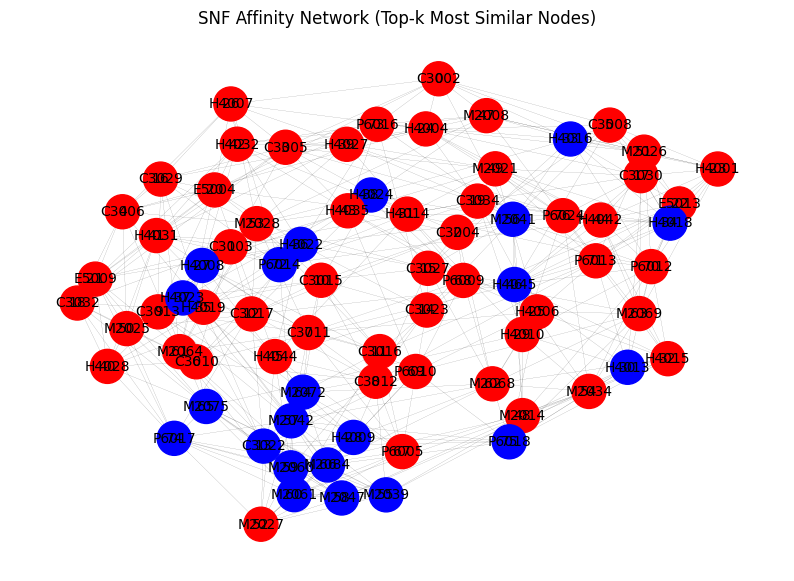

In [47]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def visualize_snf_network(affinity_matrix, top_k=5):
    """
    Build and visualize a NetworkX graph of the top-k most similar nodes
    for each node from an SNF affinity matrix.
    """
    colors = {'IBD': 'red', 'nonIBD':'blue'}
    n = affinity_matrix.shape[0]
    G = nx.Graph()

    # Add nodes
    for i in range(n):
        G.add_node(i, label=samples[i], color=colors[groups[i]])

    # Add top-k edges for each node
    for i in range(n):
        # Exclude self-similarity
        sims = affinity_matrix[i].copy()
        sims[i] = -np.inf

        # Find top-k neighbors
        top_neighbors = np.argsort(sims)[-top_k:]

        for j in top_neighbors:
            weight = affinity_matrix[i, j]
            if weight > 0:
                G.add_edge(i, j, weight=weight)

    node_labels = nx.get_node_attributes(G, 'label')
    node_colors = nx.get_node_attributes(G, 'color').values()

    # Draw graph
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G, seed=42)

    # Node drawing
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=600)
    nx.draw_networkx_labels(G, pos, font_size=10)

    # Edge drawing weighted by similarity
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(G, pos, width=[w * 5 for w in weights])
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')

    plt.title("SNF Affinity Network (Top-k Most Similar Nodes)")
    plt.axis("off")
    plt.show()

# ----- Example usage -----
# Suppose you have an SNF affinity matrix:
visualize_snf_network(fused_network, top_k=10)


### 📊 **4. Downstream Analysis: Spectral Clustering**

### **Method Explanation**

The resulting Fused Network is a similarity graph, which is ideal for **Spectral Clustering**. This method treats the clustering problem as a graph partitioning problem, using the eigenvectors of the network's Laplacian matrix to find optimal group assignments (clusters) that maximize within-cluster similarity and minimize between-cluster similarity. This is often more effective than traditional methods like $k$-means when dealing with complex, non-linear relationships captured by a similarity network.

### **Clustering Parameters**

  * **$n\_clusters$**: The target number of clusters (patient subtypes) to identify.
      * *Notebook Value:* $\mathbf{n\_clusters = 2}$ (The code is aiming to find two main patient subtypes, likely corresponding to a known disease status, given the use of **'nonIBD'** and **'IBD'** for true labels).

### **Evaluation**

The **Normalized Mutual Information (NMI)** score is used to compare the discovered clusters (`cluster_labels`) against the known **true labels** (`true_labels`).

  * **NMI Score:** A metric that measures the agreement between two clusterings (or a clustering and true labels), normalized to account for chance.
      * **Value Range:** $0.0$ (no mutual information/agreement) to $1.0$ (perfect agreement).
      * **True Labels:** The code maps the 'nonIBD' group to $0$ and the 'IBD' group to $1$.

### **Final Results Interpretation**

The output shows the final evaluation score:

```
Normalized Mutual Information (NMI) score: 0.1245
```

  * **Interpretation:** An NMI score of **$0.1245$** is relatively low (closer to $0$ than $1$). This suggests that the two clusters found by Spectral Clustering on the fused network **do not strongly align** with the simple, known binary grouping of IBD vs. nonIBD.
  * **Possible Next Steps:**
    1.  **Refine Parameters:** Re-run the analysis with different SNF parameters ($K$, $\mu$, $T$) or clustering parameters ($n\_clusters$).
    2.  **Explore Different $n\_clusters$:** The biological subtypes may not be $2$. Try a different number (e.g., $3$ or $4$) to see if the multi-omics data reveals more granular, previously unknown patient subtypes.
    3.  **Validate Subtypes:** If a new number of clusters provides better internal separation (e.g., using a Silhouette score, though not shown here), those new subtypes should be biologically validated.

In [12]:
# --- 4. Downstream Analysis (Spectral Clustering) ---
n_clusters = 2

# Use the fused network for spectral clustering
# Spectral clustering is generally the recommended method for SNF output
cluster_labels = spectral_clustering(
    fused_network,
    n_clusters=n_clusters
)
true_labels = data_dt.sort_values('sample')[['sample','group']].drop_duplicates()['group'].apply(lambda x: 0 if x == 'nonIBD' else 1)
# Optional: Evaluate the clustering (if true labels are known)
nmi = normalized_mutual_info_score(list(true_labels.values), cluster_labels)

print(f"Normalized Mutual Information (NMI) score: {nmi:.4f}")

Normalized Mutual Information (NMI) score: 0.1252


## 🔬 Multi-Omics Factor Analysis (MOFA)

This notebook implements [**Multi-Omics Factor Analysis (MOFA)**](https://biofam.github.io/MOFA2/index.html), a statistical framework designed to integrate and analyze multi-modal biological data (e.g., transcriptomics, proteomics, and metagenomics) simultaneously.

### Key Concepts

| Concept | Explanation | Interpretation Guidance |
| :--- | :--- | :--- |
| **Multi-Omics Data** (Views) | Multiple datasets measured on the **same set of samples**. For example, gene expression (RNA-seq), protein abundance, and microbial species counts are three distinct *views* of the same biological state. | Ensures that the model learns shared patterns across all data types for a given sample. |
| **Latent Factors ($\mathbf{Z}$)** | These are the **main, underlying sources of variation** identified by the model. MOFA discovers these hidden dimensions that explain the variability across all the measured omics layers. | Each factor (e.g., Factor 1) represents a specific biological process, pathway, or clinical effect (e.g., inflammation or metabolic dysregulation). The goal of the analysis is to assign a biological meaning to each factor. |
| **Factor Weights ($\mathbf{W}$)** | These quantify the **contribution of each feature** (e.g., a specific gene, protein, or microbe) to a specific latent factor. | A high absolute weight (positive or negative) means that feature is strongly associated with that factor and is important for defining the underlying biological process it represents. |
| **Sparsity** | MOFA uses *sparsity priors* (like Spike-and-Slab) during training, which encourages the factor weights of irrelevant features to be set near zero. | This automatically performs feature selection, making the final set of factors highly interpretable by highlighting only the most relevant features across the different omics views. |

***

## MOFA Implementation Packages

The MOFA framework is split into two primary Python packages for a clear workflow:

1.  **`mofapy2` (Model Building and Training)**
    * This package handles the data preparation, configuration of the core Variational Bayes model, and the computationally intensive training process.
    * It allows you to specify the **likelihood distribution** (e.g., Gaussian for continuous data like proteomics, Poisson for count data like RNA-seq) for each omics view, ensuring the model fits the data appropriately.

2.  **`mofax` (Model Analysis and Visualization)**
    * This package is used *after* the model is trained and saved.
    * It provides dedicated functions for extracting the latent factors, weights, and explained variance, and generating publication-ready plots for in-depth biological interpretation.

In [13]:
! pip install mofapy2
! pip install mofax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 6.4 MB/s eta 0:00:00


### 1. Setup and Data Retrieval

Before we can build the model, we need to prepare the environment and load the data.

1.  **Directory Setup**: We create a `multiomics` directory with `data` and `results` subfolders to keep our project organized.
2.  **Data Download**: We use `!wget` to download the example dataset (`multiomics_views.tsv`) from its source repository. This file contains data for three different omics types (views) across multiple samples and groups.

### 2. Model Configuration (mofapy2)

This is the most critical step, where we define the parameters for our MOFA model using the `entry_point`.

### Methods Used

* **Data Loading**: The `.tsv` file is loaded into a pandas DataFrame.
* **Data Options**: We set `scale_views = False`. If set to `True`, this would scale all views to have the same variance, which can be useful if one view has much higher variance than others, but here we keep the original variance.
* **Likelihoods**: This is key for multi-modal data. We specify the statistical distribution for each view:
    * `"gaussian"`: Used for continuous data (like proteomics or metagenomics).
    * `"poisson"`: Used for non-negative integer count data (like transcriptomics/RNA-seq counts).
* **Model Options**:
    * `factors = 10`: We initialize the model with 10 latent factors (dimensions of shared variation).
    * `spikeslab_weights = True` & `ard_weights = True`: These options enable sparsity priors. This is a form of regularization that encourages the model to set weights for irrelevant features to zero, making the results easier to interpret.
* **Train Options**:
    * `convergence_mode = "fast"`: Uses a less strict convergence criterion for faster training.
    * `gpu_mode = True`: This accelerates the computationally intensive training process by using the GPU.

In [14]:
from mofapy2.run.entry_point import entry_point
import mofax
import pandas as pd

## --- 1. Prepare Data ---
# MOFA expects a list of data matrices (samples x features)
# Let's simulate two datasets: mRNA and Proteomics
D = [25, 25, 25] # Number of features per view
M = len(D)      # Number of views
K = 5           # Number of factors
N = [55, 22]   # Number of samples per group
G = len(N)      # Number of groups

data_dt = pd.read_csv("multiomics/data/multiomics_views.tsv", sep="\t")


# initialise the entry point
ent = entry_point()
ent.set_data_options(
    scale_views = False
)
ent.set_data_df(data_dt, likelihoods = ["gaussian","gaussian", "poisson"])

ent.set_model_options(
    factors = 10,
    spikeslab_weights = True,
    ard_weights = True
)

ent.set_train_options(
    convergence_mode = "fast",
    dropR2 = 0.001,
    gpu_mode = True,
    seed = 1
)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


Loaded group='IBD' view='metagenomics' with N=55 samples and D=25 features...
Loaded group='IBD' view='proteomics' with N=55 samples and D=25 features...
Loaded group='IBD' view='transcriptomics' with N=55 samples and D=25 features...
Loaded group='nonIBD' view='metagenomics' with N=22 samples and D=25 features...
Loaded group='nonIBD' view='proteomics' with N=22 samples and D

### 3. Model Training

Now we build and run the model.

* `ent.build()`: This constructs the `mofapy2` model object based on the options we just defined.
* `ent.run()`: This executes the model training. The model uses variational inference to find the latent factors.
* `ent.save()`: The trained model is saved to an `.hdf5` file, which allows us to load it for analysis without re-training.

### How to Interpret the Training Output

The output you see during training shows the model's convergence:

* **ELBO (Evidence Lower Bound)**: This is the value the model is trying to maximize. You should see the ELBO value consistently increasing, which means the model is learning.
* **deltaELBO**: This is the change in the ELBO from the previous iteration. As the model converges, this value will get very small.
* **Factors**: The model may automatically "drop" (prune) factors that are not explaining significant variance. You can see this number decrease (e.g., from 9 to 8) in the log.

In [15]:
ent.build()
ent.run()

# Save the output
ent.save(outfile="mofa_model.hdf5")



######################################
## Training the model with seed 1 ##
######################################


ELBO before training: -3316197229.42 

Iteration 1: time=1.52, ELBO=-348754730.19, deltaELBO=2967442499.227 (89.48329348%), Factors=9
Iteration 2: time=0.12, ELBO=-102675991.21, deltaELBO=246078738.980 (7.42050976%), Factors=9
Iteration 3: time=0.12, ELBO=-44983711.47, deltaELBO=57692279.744 (1.73971196%), Factors=8
Iteration 4: time=0.06, ELBO=-6416803.91, deltaELBO=38566907.558 (1.16298594%), Factors=8
Iteration 5: time=0.07, ELBO=20093545.72, deltaELBO=26510349.629 (0.79942017%), Factors=8
Iteration 6: time=0.13, ELBO=40277571.38, deltaELBO=20184025.659 (0.60864974%), Factors=8
Iteration 7: time=0.14, ELBO=56760760.46, deltaELBO=16483189.078 (0.49705093%), Factors=8
Iteration 8: time=0.06, ELBO=70899047.80, deltaELBO=14138287.341 (0.42634036%), Factors=8
Iteration 9: time=0.10, ELBO=83529575.51, deltaELBO=12630527.709 (0.38087384%), Factors=8
Iteration 10: time=0.06

### 4. Analysis of Results (mofax)

Once the model is trained, we switch to the `mofax` package for interpretation and visualization.

### Method: Plotting Factor Weights

The `plot_weights` function shows the "weights" of the top features for each factor. These weights indicate how much each feature (e.g., a specific gene, protein, or microbe) contributes to each latent factor.

### How to Interpret the Weights Plot

This plot is the primary result for understanding the biology captured by the model:

* **Factors (Y-axis)**: Each row (e.g., Factor 1, Factor 2) represents one of the latent factors of variation discovered by MOFA.
* **Views (Columns)**: The plot is separated into the different omics types (metagenomics, proteomics, transcriptomics).
* **Feature Weights (X-axis)**: The bars represent individual features. A long bar (positive or negative) means that feature has a high "weight" and is strongly associated with that factor.
* **Putting it all together**: You look for factors that are "active" across multiple views. For example, **Factor 1** might have high weights for specific features in the 'proteomics' view AND high weights for features in the 'metagenomics' view. This suggests a shared biological axis that links specific microbes to specific proteins. By examining *which* features have high weights, you can infer the biological process this factor represents.

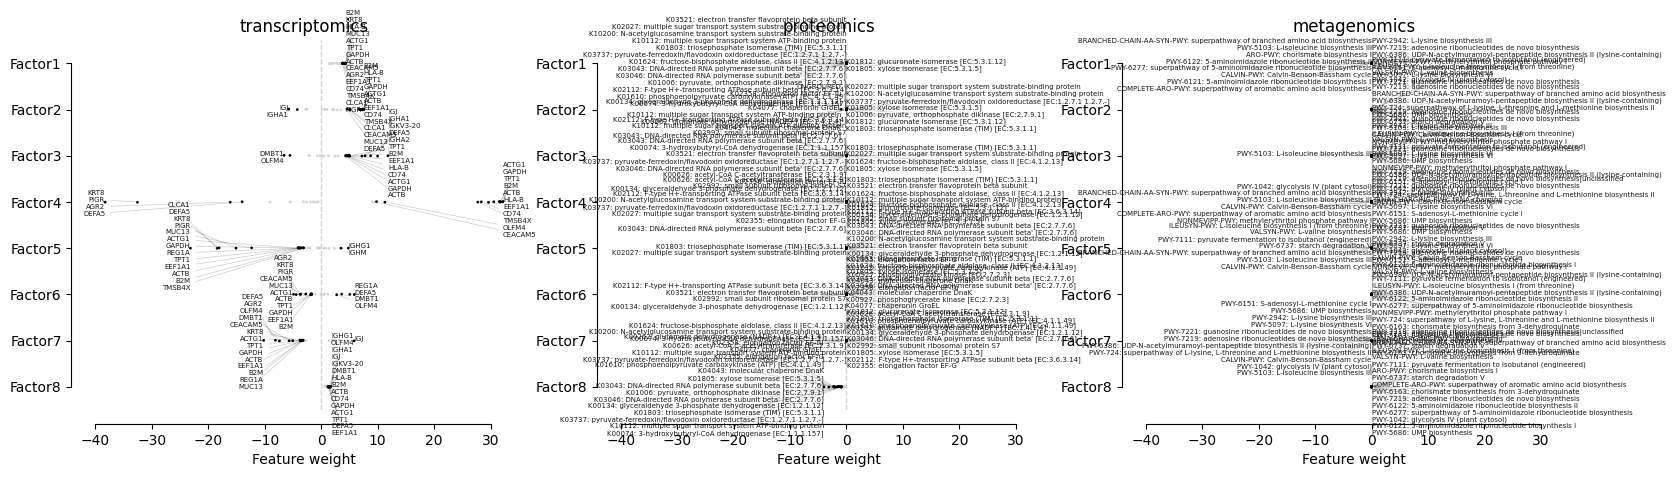

In [16]:
## --- 3. Analyze the Model (mofax) ---
# Load the trained model
model = mofax.mofa_model("mofa_model.hdf5")

ax = mofax.plot_weights(model, n_features=15)


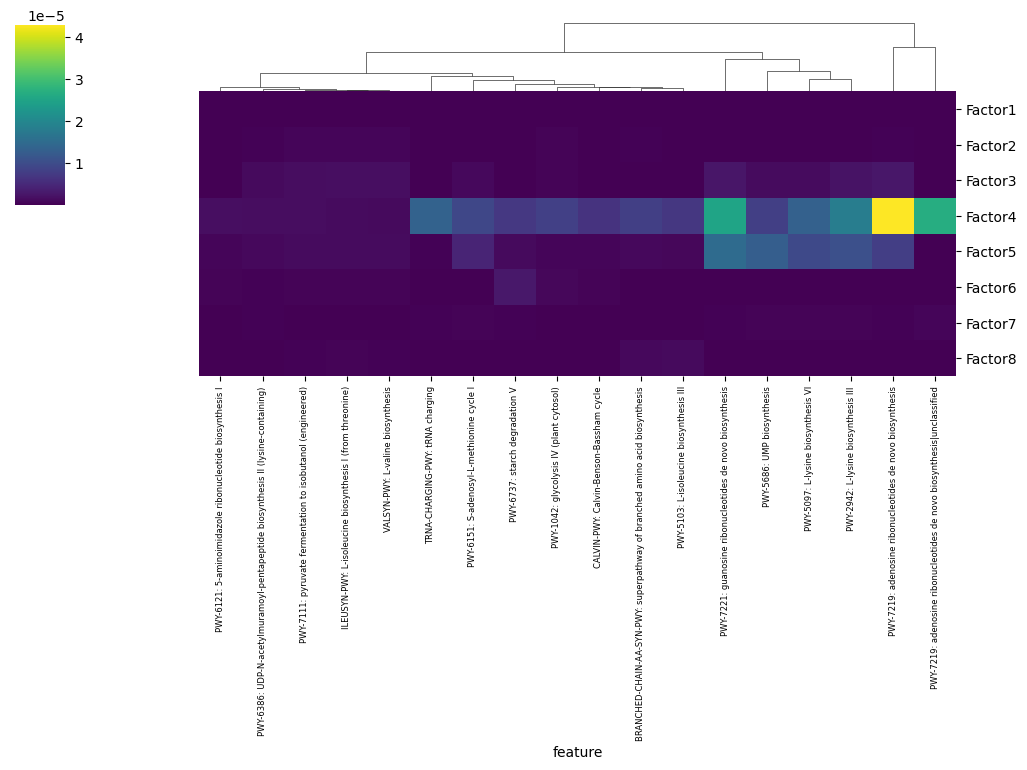

In [17]:
mofax.plot_weights_heatmap(model, n_features=5,
                         factors=range(0, 8),
                         xticklabels_size=6, w_abs=True,
                         cmap="viridis", cluster_factors=False)

<Axes: title={'center': 'Factor5'}, xlabel='Factor1', ylabel='Factor5'>

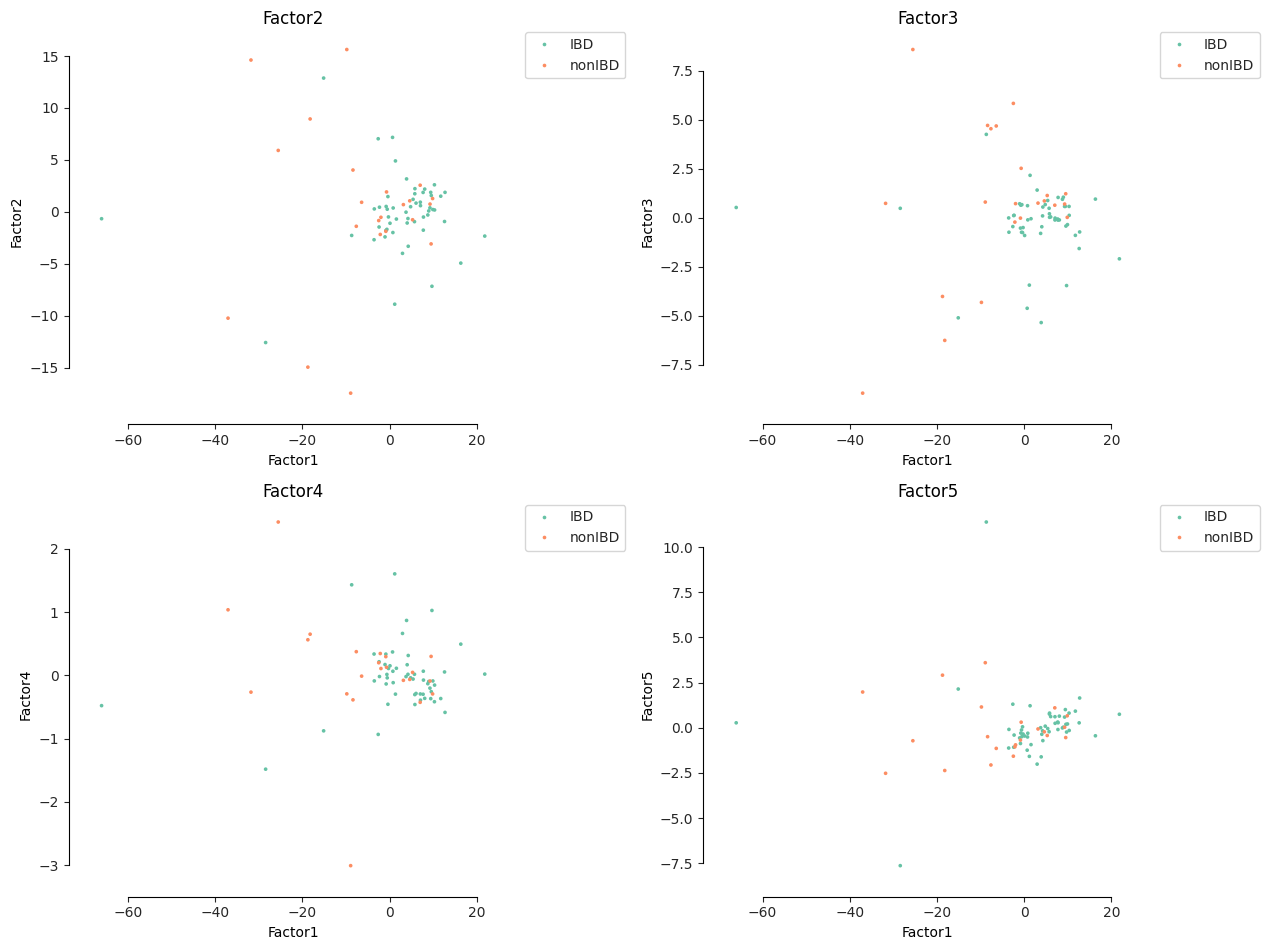

In [18]:
mofax.plot_factors_scatter(model, x=0, y=range(1, 5),
                         size=7,
                         color="group",
                         legend='brief', ncols=2)


<Axes: title={'center': 'Factor8'}, xlabel='group', ylabel='Factor8'>

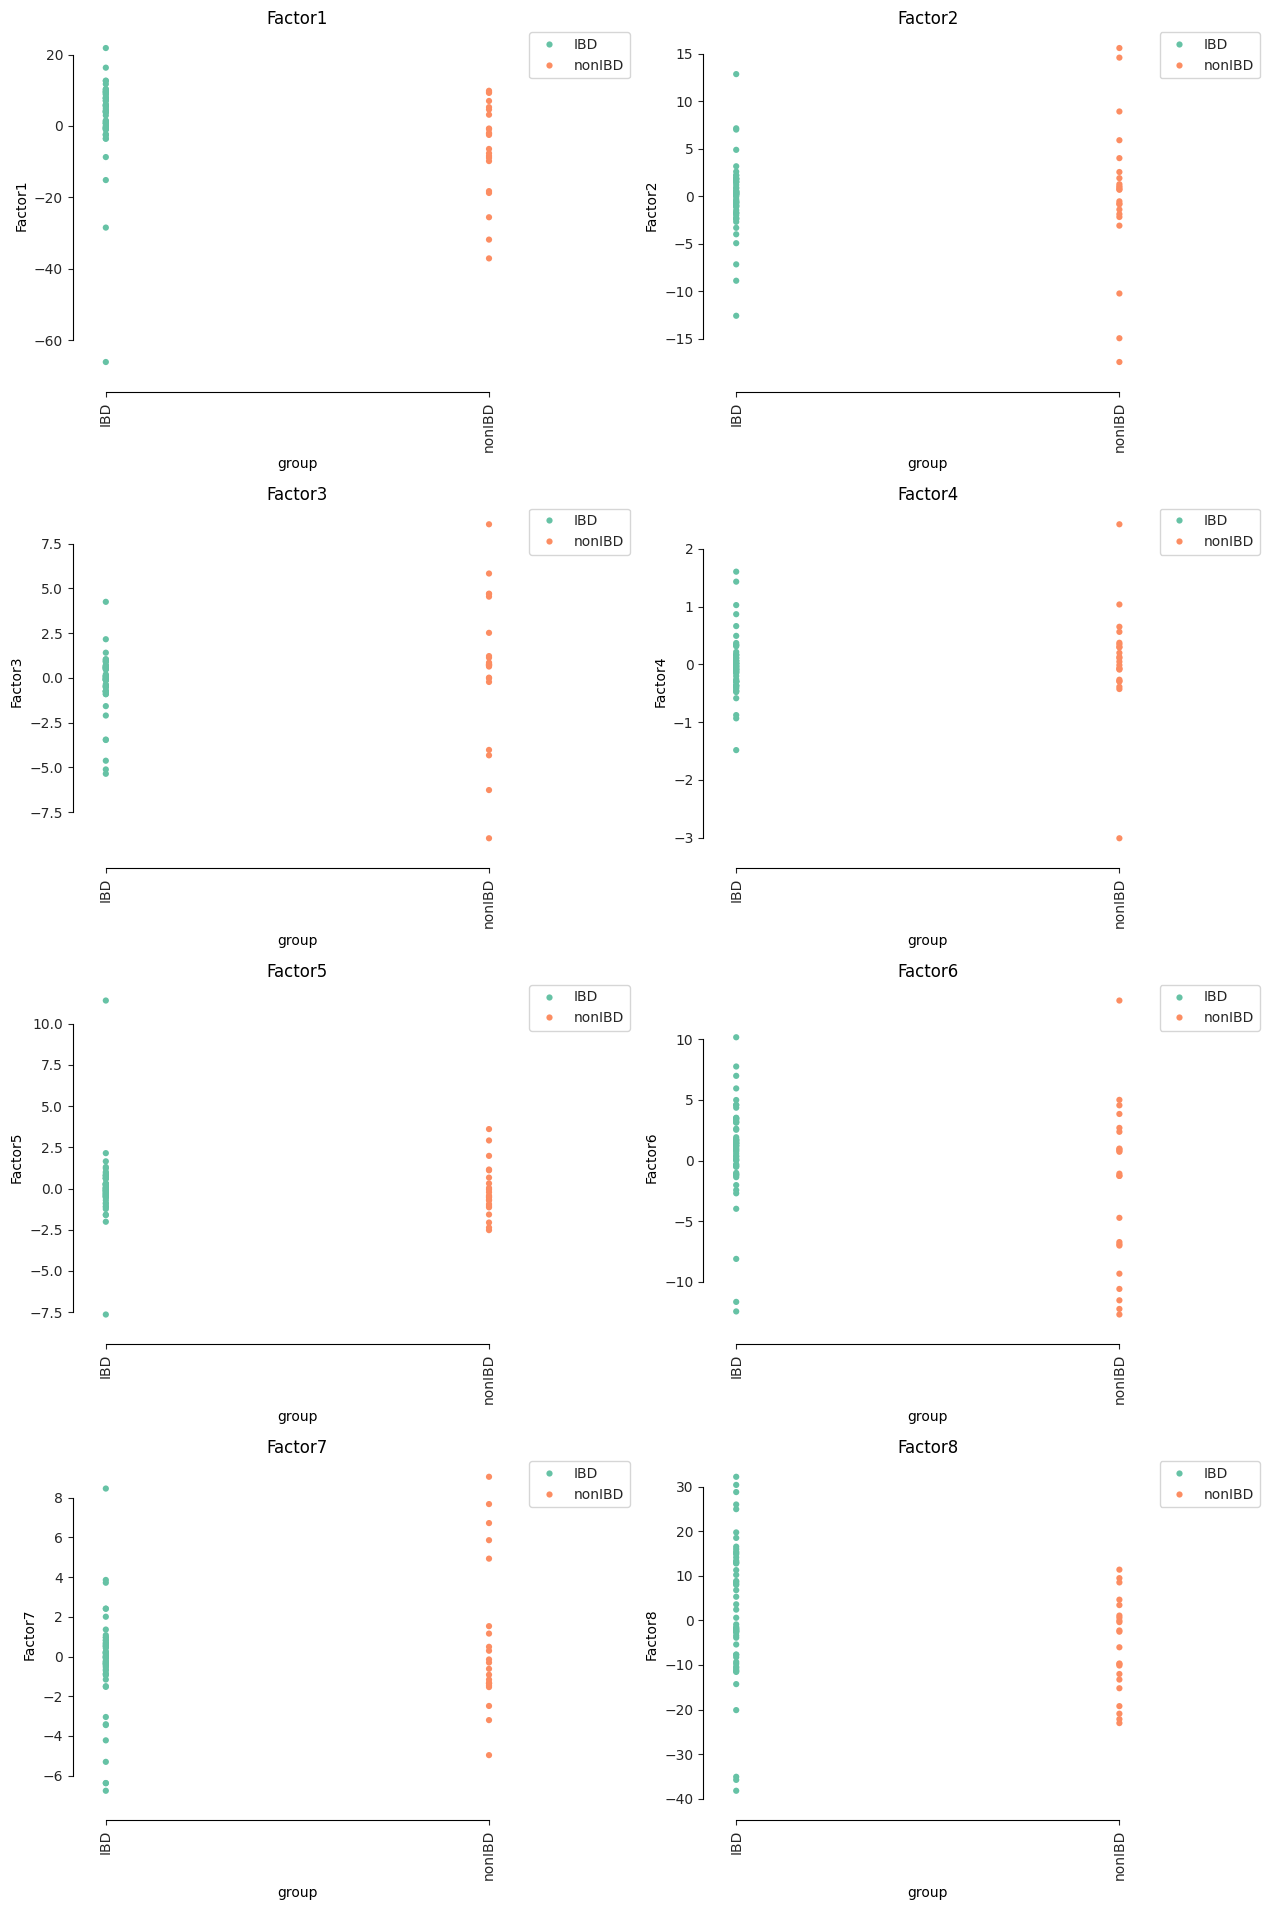

In [19]:
mofax.plot_factors_scatter(
    model,
    x="group", y=range(8), group_label="group", color='group',
    alpha=1.,
    rotate_x_labels=90, ncols=2,
)

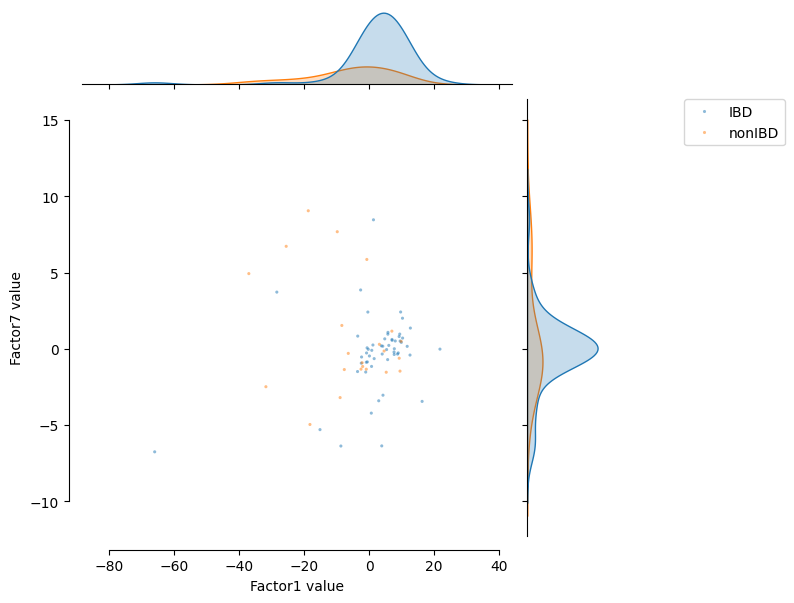

In [20]:
mofax.plot_factors_scatter(model, x="Factor1", y="Factor7",
                         size=5, alpha=.5,
                         dist=True,
                         color="group")